In [20]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [ ]:
import os
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq duckduckgo_search
    !pip install -Uqq fastai
    
# make sure you have python 3.10 and duckduckgo 3.9.5
import sys
print(sys.version)

import duckduckgo_search
print(duckduckgo_search.__version__)

In [24]:
from itertools import islice
from duckduckgo_search import DDGS
from fastcore.all import *


def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    # DDGS().images return an interator containing all images found
    # we use islice to limit the number of results returned
    return L(islice(DDGS().images(term), max_images)).itemgot('image')

In [25]:
urls = search_images('bird photos', max_images=1)
urls[0]

Searching for 'bird photos'


'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

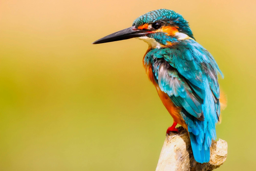

In [26]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256,256)

Searching for 'forest photos'


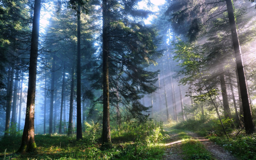

In [27]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256,256)

In [28]:
searches = 'forest','bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{o} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{o} shade photo'))
    sleep(10)
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'forest photo'
Searching for 'forest sun photo'
Searching for 'forest shade photo'
Searching for 'bird photo'
Searching for 'bird sun photo'
Searching for 'bird shade photo'


In [29]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

5

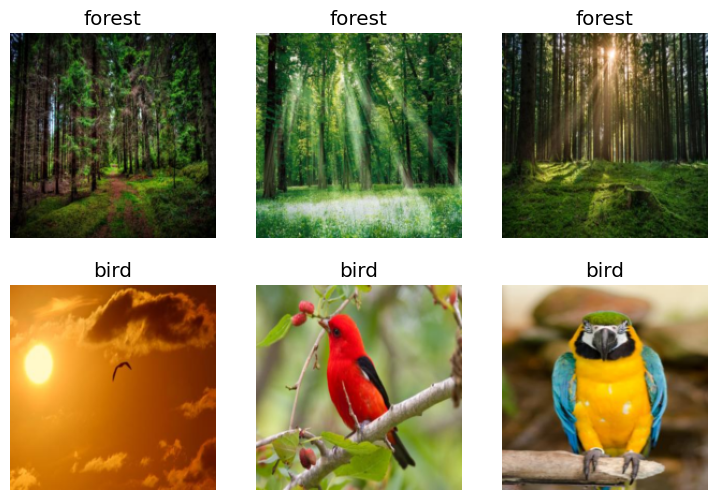

In [30]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

In [33]:
blocks=(ImageBlock, CategoryBlock),

In [35]:
get_items=get_image_files, 


In [36]:
splitter=RandomSplitter(valid_pct=0.2, seed=42),


In [37]:
get_y=parent_label,


In [38]:
item_tfms=[Resize(192, method='squish')]


In [39]:
learn = vision_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\Binny/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:15<00:00, 2.95MB/s]


epoch,train_loss,valid_loss,error_rate,time
0,0.983958,0.931271,0.303030,00:16


epoch,train_loss,valid_loss,error_rate,time
0,0.155286,0.058884,0.000000,00:23
1,0.148528,0.013381,0.000000,00:37
2,0.099261,0.016137,0.000000,00:22


In [40]:
is_bird,_,probs = learn.predict(PILImage.create('bird.jpg'))
print(f"This is a: {is_bird}.")
print(f"Probability it's a bird: {probs[0]:.4f}")

This is a: bird.
Probability it's a bird: 0.9984
